In [1]:
import os
import torch
import torchvision
import matplotlib
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.optim.lr_scheduler import StepLR
import torchvision.transforms as tt
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F
%matplotlib inline

OSError: [WinError 126] The specified module could not be found. Error loading "C:\Users\rachi\anaconda3\Lib\site-packages\torch\lib\fbgemm.dll" or one of its dependencies.

In [2]:
datasetDir = "/kaggle/input/micro-expressions/Micro_Expressions"
classes = os.listdir(datasetDir + "/train")
print("Expression Labels: ",classes)

# tfms = tt.Compose([
#     tt.RandomResizedCrop(80, scale=(0.8, 1.0)),
#     tt.RandomHorizontalFlip(),
#     tt.RandomVerticalFlip(),
#     tt.RandomRotation(20),
#     tt.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
#     tt.RandomCrop(80, padding=15, padding_mode='reflect'),
#     tt.ToTensor(),
#     tt.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])
# dataset1 = ImageFolder(datasetDir+"/train",tfms)
# dataset2 = ImageFolder(datasetDir+"/train",transform=ToTensor())
# dataset = dataset1+dataset2
# dataset.classes = ['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']

Expression Labels:  ['surprise', 'fear', 'neutral', 'sadness', 'disgust', 'happiness', 'anger']


In [3]:
# data augmentation
tfmsOther = tt.Compose([tt.RandomCrop(80, padding=15, padding_mode='reflect'),
                        tt.RandomHorizontalFlip(),
                        tt.ToTensor()])
tfmsOtherBlur = tt.Compose([tt.RandomCrop(80, padding=15, padding_mode='reflect'),
                        tt.RandomHorizontalFlip(),tt.GaussianBlur(kernel_size=3, sigma=10),
                        tt.ToTensor()])
tfmsBlur = tt.Compose([tt.GaussianBlur(kernel_size=3, sigma=10),tt.ToTensor()])
tfmsRotate = tt.Compose([tt.RandomRotation(degrees=(-45, 45)),tt.ToTensor()])
tfmsRotateBlur = tt.Compose([tt.GaussianBlur(kernel_size=3, sigma=10),tt.RandomRotation(degrees=(-45, 45)),tt.ToTensor()])

#Loading the dataset as pyTorch Tensors
dataset1 = ImageFolder(datasetDir+"/train",transform=ToTensor()) #original
dataset2 = ImageFolder(datasetDir+"/train",tfmsBlur) #original blur
dataset3 = ImageFolder(datasetDir+"/train",tfmsRotate) #rotated
dataset4 = ImageFolder(datasetDir+"/train",tfmsRotateBlur) #rotated blurred
dataset5 = ImageFolder(datasetDir+"/train",tfmsOther) #other augments
dataset6 = ImageFolder(datasetDir+"/train",tfmsOtherBlur) #other augments blurred
#Combining normal and augmented datasets
dataset = dataset1+dataset2+dataset3+dataset4+dataset5+dataset6
dataset.classes = ['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']

## Splitting of Trianing set

In [4]:
randomSeed = 3 
torch.manual_seed(randomSeed)
valSize = 2000
trainSize = len(dataset)-valSize
trainDS, valDS = random_split(dataset,[trainSize,valSize])

In [5]:
batchSize = 200
trainDL = DataLoader(trainDS,batchSize,shuffle=True,num_workers=4, pin_memory=True)
valDL = DataLoader(valDS,batchSize*2,num_workers=4, pin_memory=True)

In [6]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)   
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean() 
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {} , train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

## CNN based Model

In [7]:
class ATTModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
    
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, 2),

            nn.Dropout2d(p=0.5),
    
            nn.Flatten(),
            nn.Linear(256*10*10, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
            #nn.Softmax(-1)
        
    def forward(self, xb):
        return self.network(xb)

In [8]:
# Weight initialization function
def initialize_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)

In [9]:
# Model structure
model = ATTModel()

# Apply weight initialization to the model
model.apply(initialize_weights)

print(model)

ATTModel(

  (network): Sequential(

    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

    (1): ReLU()

    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

    (4): ReLU()

    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

    (8): ReLU()

    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

    (11): ReLU()

    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

    (14): Conv2d(128, 256, kernel_size=(3, 3), stride

In [10]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device): 
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

device = get_default_device()
train_dl = DeviceDataLoader(trainDL, device)
val_dl = DeviceDataLoader(valDL, device)
to_device(model, device);

In [11]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
        
    return history

## Model Training

In [12]:
model = to_device(ATTModel(), device)
num_epochs = 50
opt_func = torch.optim.Adam
lr = 0.001
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch 0 , train_loss: 1.6367, val_loss: 1.2551, val_acc: 0.5330

Epoch 1 , train_loss: 1.1134, val_loss: 0.9501, val_acc: 0.6500

Epoch 2 , train_loss: 0.8616, val_loss: 0.8400, val_acc: 0.6930

Epoch 3 , train_loss: 0.7060, val_loss: 0.7227, val_acc: 0.7535

Epoch 4 , train_loss: 0.5955, val_loss: 0.6125, val_acc: 0.7770

Epoch 5 , train_loss: 0.5214, val_loss: 0.5619, val_acc: 0.8100

Epoch 6 , train_loss: 0.4676, val_loss: 0.5044, val_acc: 0.8300

Epoch 7 , train_loss: 0.4264, val_loss: 0.4432, val_acc: 0.8520

Epoch 8 , train_loss: 0.3923, val_loss: 0.4107, val_acc: 0.8565

Epoch 9 , train_loss: 0.3651, val_loss: 0.4082, val_acc: 0.8610

Epoch 10 , train_loss: 0.3424, val_loss: 0.3805, val_acc: 0.8760

Epoch 11 , train_loss: 0.3216, val_loss: 0.3628, val_acc: 0.8785

Epoch 12 , train_loss: 0.3056, val_loss: 0.3291, val_acc: 0.8905

Epoch 13 , train_loss: 0.2898, val_loss: 0.3303, val_acc: 0.8885

Epoch 14 , train_loss: 0.2705, val_loss: 0.3350, val_acc: 0.8860

Epoch 15 , train_los

## verification of the accuracy

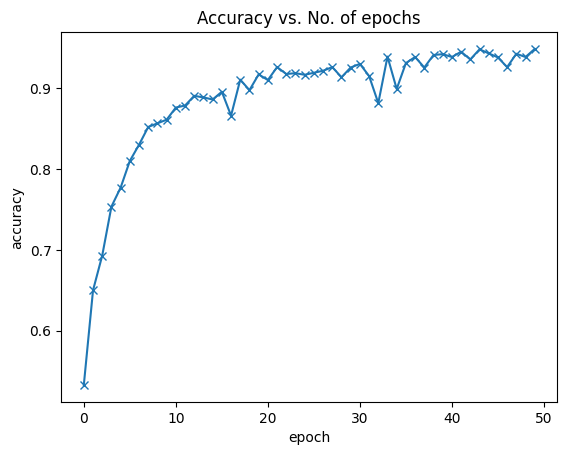

In [13]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

plot_accuracies(history)

In [14]:
# Training and validation loss
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

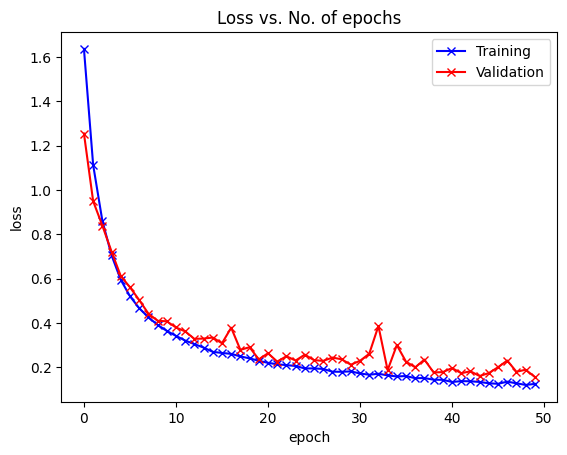

In [15]:
plot_losses(history)

In [16]:
def predict_image(image, model):
    xb = to_device(image.unsqueeze(0), device)  
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1) 
    return dataset.classes[preds[0].item()]

Label: anger , Predicted: anger


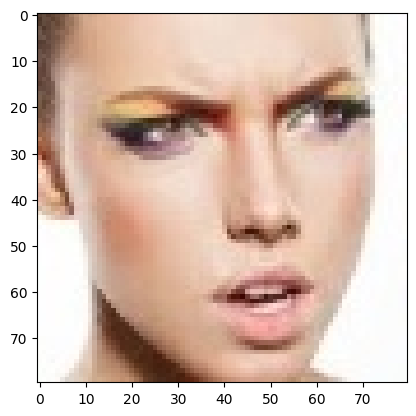

In [17]:
test_dataset = ImageFolder(datasetDir+'/test', transform=ToTensor())
image, label = test_dataset[69]
plt.imshow(image.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(image, model))


Label: anger , Predicted: anger


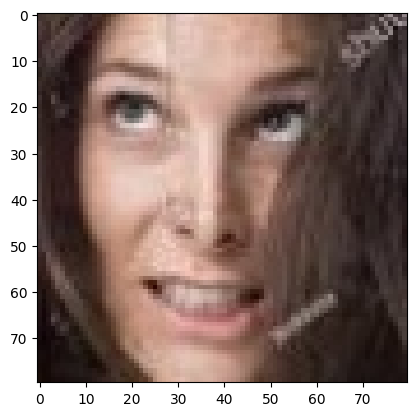

In [18]:
image, label = test_dataset[150]
plt.imshow(image.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(image, model))

## Testing accuracy of the model

In [19]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batchSize*2), device)
result = evaluate(model, test_loader)
print("test loss:",result['val_loss'])
print("test accuracy:",result['val_acc'])

test loss: 1.008118987083435

test accuracy: 0.8503077626228333


In [20]:
torch.save(model.state_dict(),'mode.pth')

In [21]:
modelSaved = to_device(ATTModel(),device)
modelSaved.load_state_dict(torch.load('mode.pth'))

<All keys matched successfully>